# 機器學習模型解釋：SHAP 值介紹

### Shapley values 其實就是想要衡量個別的特徵對模型的貢獻程度為何!

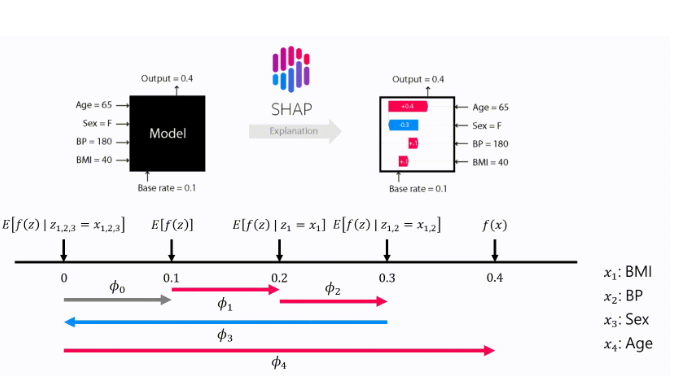
## 簡介

您已經見過並使用了多種技術來從機器學習模型中提取一般性見解。但如果您想要深入了解模型對於單個預測的運作方式，該怎麼做呢？

SHAP 值（SHAP 是 SHapley Additive exPlanations 的縮寫）能夠將預測分解，展示每個特徵的影響。這樣的技術在哪裡可以應用呢？

- 一個模型判斷銀行不應該向某人貸款，而銀行在法律上被要求解釋每一次貸款拒絕的依據
- 醫療提供者希望確定哪些因素驅動了每位患者的某種疾病風險，從而可以針對這些風險因素進行有針對性的健康干預

在本筆記中，您將使用 SHAP 值來解釋個別預測。在下一節中，您將看到如何將這些值聚合成強大的模型層級見解。

## 運作原理

SHAP 值通過將某一特徵取某個基準值時的預測結果與實際值進行對比，來解釋該特徵的具體值對預測結果的影響。

舉個例子，讓我們繼續使用在排列重要性和部分依賴圖課程中的例子。

在這些範例中，我們預測了一支球隊是否會有球員獲得全場最佳球員獎。

我們可以問：

- 預測結果有多大程度上受到球隊進了 3 個球的影響？

但如果我們將其改述為：

- 預測結果有多大程度上受到球隊進了 3 個球，而不是進了一個基準數量的球的影響？

那麼給出具體的數字答案就更容易了。

當然，每支球隊都有許多特徵。因此，如果我們回答了進球數這個問題，我們可以對所有其他特徵重複這個過程。

SHAP 值以一種保證了良好性質的方式來實現這一點。具體而言，您可以用以下方程來分解一個預測：

sum(SHAP 值 for all features) = 團隊的預測值 - 基準值的預測值

也就是說，所有特徵的 SHAP 值之和可以解釋為什麼我的預測值會不同於基準值。這使得我們可以在圖表中這樣分解一個預測：

---

這樣的方法使我們能夠具體分析每一個特徵對於模型預測結果的貢獻，從而更全面地了解模型的運作原理及其決策依據。

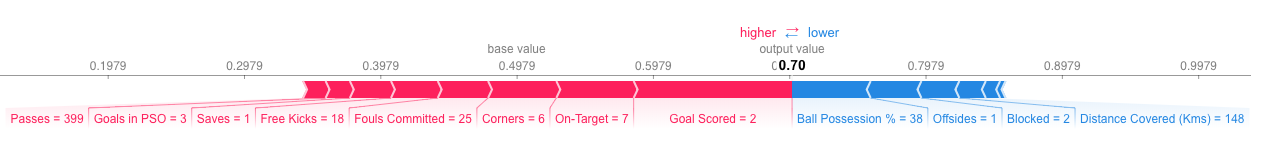


## 如何解釋這個結果？

我們的預測值是 0.7，而基準值是 0.4979。導致預測值增加的特徵值用粉紅色表示，其視覺大小顯示了該特徵影響的幅度。導致預測值減少的特徵值用藍色表示。對預測值影響最大的特徵是進球數為 2。儘管控球率的值也對預測值有顯著的減少效果。

如果將藍色條的長度從粉紅色條的長度中減去，其結果等於基準值與輸出值之間的距離。

[ref](https://medium.com/ai-academy-taiwan/%E5%8F%AF%E8%A7%A3%E9%87%8B-ai-xai-%E7%B3%BB%E5%88%97-shap-2c600b4bdc9e)

In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('./FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [63]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


my_model.predict_proba(data_for_prediction_array)

c:\Users\sunny_weng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.29, 0.71]])

The team is 70% likely to have a player win the award.

Now, we'll move onto the code to get SHAP values for that single prediction.

In [64]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [91]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[:, 1], data_for_prediction)

If you look carefully at the code where we created the SHAP values, you'll notice we reference Trees in shap.TreeExplainer(my_model). But the SHAP package has explainers for every type of model.

shap.DeepExplainer works with Deep Learning models.
shap.KernelExplainer works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.
Here is an example using KernelExplainer to get similar results. The results aren't identical because KernelExplainer gives an approximate result. But the results tell the same story.

In [95]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(my_model.predict_proba, train_X)

# Calculate Shap values
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[:, 1], data_for_prediction)

## 進階 shap 值應用


我們首先學習了排列重要性和部分依賴圖，以概覽模型學到的內容。

接著，我們學習了 SHAP 值來分解個別預測的組成部分。

現在，我們將擴展 SHAP 值的應用，看看如何通過聚合多個 SHAP 值來提供比排列重要性和部分依賴圖更詳細的替代方案。

### SHAP 值計算回顧

SHAP 值展示了某一特定特徵相較於其基準值，改變我們預測結果的程度。

例如，考慮一個極其簡單的模型：

y= 4∗x1 + 2∗x2


如果 x1 取值為 2，而不是基準值 0，那麼 x1 的 SHAP 值將是 8（來自於 4 乘以 2）。

對於我們實際使用的複雜模型，這些值的計算要困難得多。但通過一些算法上的巧妙設計，SHAP 值使我們能夠將任何預測分解為各個特徵值影響的總和，詳細範例如下



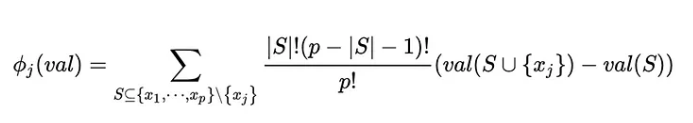

符號和定義

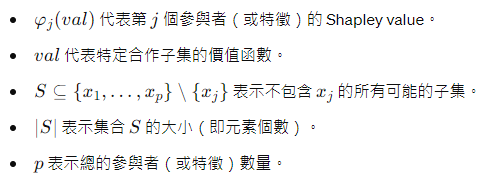





### 範例
假設工程師們需要合作寫一個 project，共計 100 行 code，圖一 顯示了工程師期望產出 code 的行數，也就是對應的 val(S)



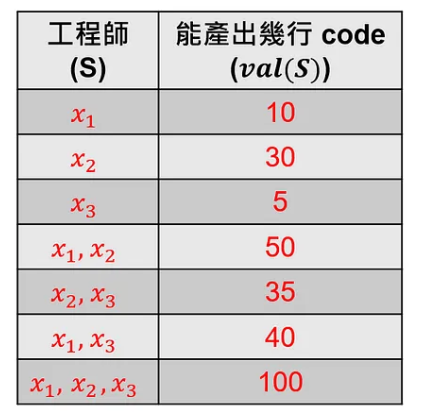<br>
圖一 工程師期望產出 code 的行數

而我們想要計算出 x1 這位工程師的 Shapley values，也就是他的貢獻值該如何計算呢？我們來看一下 圖二 的計算流程，三位工程師，因此會有六種排列組合，需要針對每種情形來計算出 x1 的 Shapley value，因為先後順序是會影響他的貢獻值的，接著再把六個值加總平均就可以得到 x1 的 Shapley values 了。


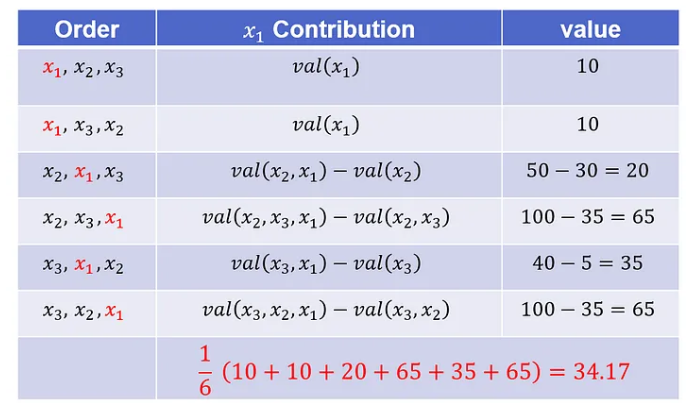<br>
圖二 x1 的 Shapley values 計算流程


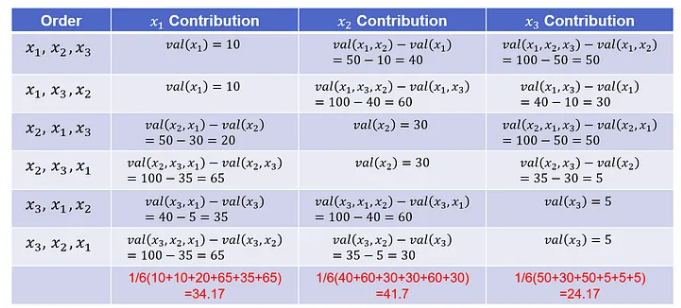<br>
圖三，x1, x2, x3 的 Shapley values 計算過程

## Summary Plots

排列重要性（Permutation Importance）非常有用，因為它創造了簡單的數值測量來了解哪些特徵對模型很重要。這有助於我們輕鬆地比較特徵之間的差異，並且可以將生成的圖表展示給非技術觀眾。

但它並未告訴您每個特徵的重要性來源。如果一個特徵具有中等的排列重要性，這可能意味著它對少數預測有很大的影響，但對大多數預測沒有影響，或者它對所有預測都有中等的影響。

SHAP（SHapley Additive exPlanations）摘要圖表為我們提供了特徵重要性及其驅動因素的鳥瞰圖。我們將通過美式足球數據的一個示例圖表來演示這一點：

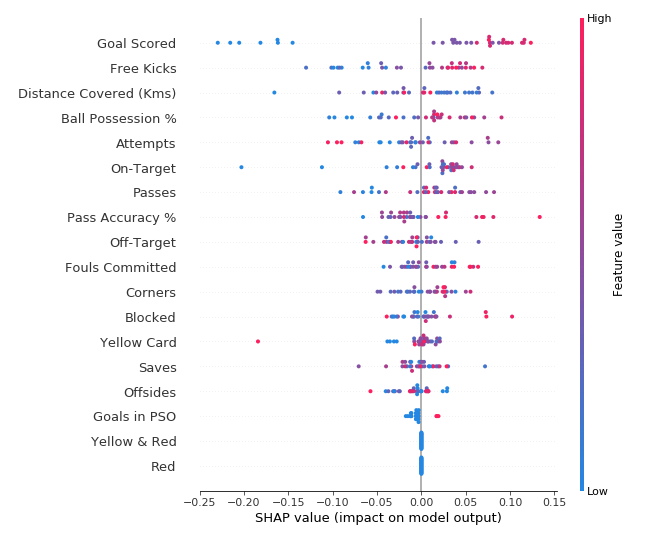

這個圖表由許多點組成。每個點具有三個特徵：

- 垂直位置顯示它描繪的是哪個特徵
- 顏色顯示該特徵對數據集的那一行是高值還是低值
- 水平位置顯示該值的效果是導致更高還是更低的預測
例如，左上角的點表示一支進球很少的球隊，這降低了預測值0.25。

一些你應該能夠輕鬆挑出的信息：

- 模型忽略了紅牌和紅黃牌這兩個特徵。
- 通常，黃牌不影響預測，但有一個極端情況，高值導致預測值大幅降低。
- 進球數的高值導致了更高的預測，而低值則導致了更低的預測。



In [98]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('./FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

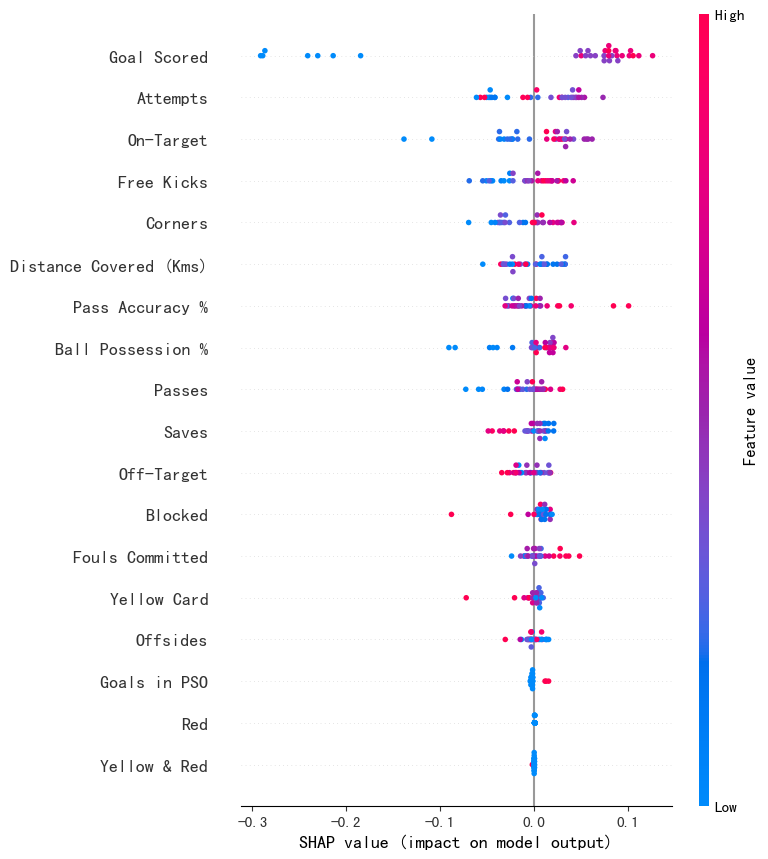

In [123]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[:, : , 1], val_X)

## SHAP Dependence Contribution Plots

我們之前使用過部分依賴圖（Partial Dependence Plots，PDP）來顯示單個特徵如何影響預測。這些圖表對於許多現實世界的應用來說都非常有見地且相關。而且，只需稍加努力，就可以向非技術觀眾解釋這些圖表。

但部分依賴圖有很多不足之處。例如，影響的分佈是怎樣的？擁有某個特定值的影響是否非常穩定，還是會隨著其他特徵的值而有很大變化？SHAP 依賴貢獻圖提供了與部分依賴圖相似的見解，但它們增加了更多細節。

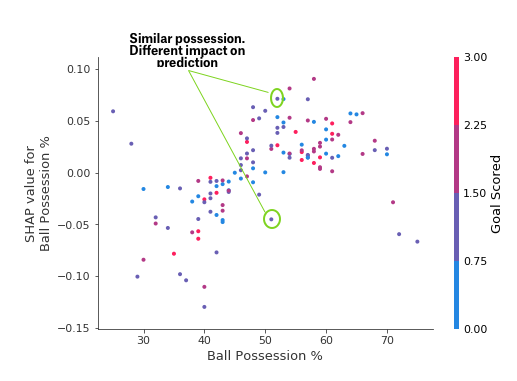

我們首先關注圖形的形狀，稍後再討論顏色。每個點代表數據中的一行。水平位置是數據集中的實際值，垂直位置顯示該值對預測的影響。這條斜線向上傾斜，表示擁有球權越多，模型對贏得最佳球員獎（Man of the Match）的預測就越高。

這種擴散表明其他特徵必須與控球率互動。例如，我們在這裡突出顯示了兩個具有相似控球率值的點。這個值導致一個預測增加，而導致另一個預測減少。


## 與線性模型比較

相比之下，簡單的線性回歸會產生完美的直線圖，沒有這種擴散。

這表明我們應該深入研究特徵之間的互動，圖表中包含的顏色編碼有助於這一點。雖然主要趨勢是向上的，但你可以通過顏色來視覺化檢查這是否會有所變化。

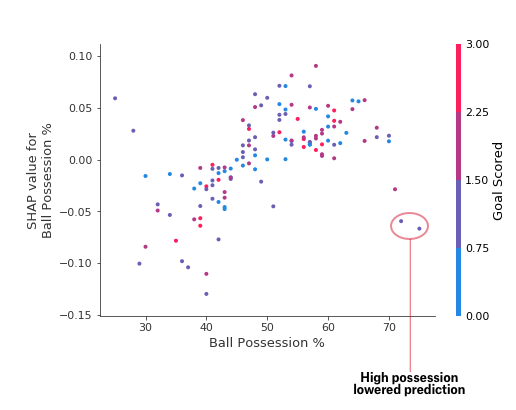

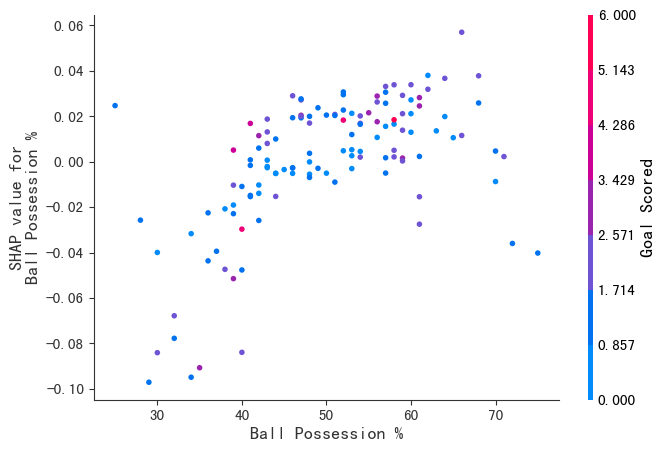

In [134]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[:,:,1], X, interaction_index="Goal Scored")